In [9]:
# %load test_with_helium.py
import pyc2ray as pc2r, os
import numpy as np, matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cst

from matplotlib.colors import LogNorm

from pyc2ray.lib import libasora_He as asora_he

In [3]:
# min and max frequency of the integral
freq_min, freq_max = (13.598*u.eV/cst.h).to('Hz').value, (54.416*u.eV/cst.h).to('Hz').value

# calculate tau value
minlogtau, maxlogtau, NumTau = -20.0, 4.0, 20000
tau, dlogtau = pc2r.make_tau_table(minlogtau, maxlogtau, NumTau)

# calculate the table
radsource = pc2r.radiation.blackbody.BlackBodySource_Multifreq(1e5, False)
photo_thin_table, photo_thick_table = radsource.make_photo_table(tau, freq_min, freq_max, 1e48)
heat_thin_table, heat_thick_table = radsource.make_heat_table(tau, freq_min, freq_max, 1e48)

# read cross section
freq, sigma_HI, sigma_HeI, sigma_HeII = np.loadtxt('/home/mbianco/codes/pyC2Ray/pyc2ray/tables/multifreq/Verner1996_crossect.txt', unpack=True)
sigma_HI = sigma_HI.ravel()
sigma_HeI = sigma_HeI.ravel()
sigma_HeII = sigma_HeII.ravel()

# number of frequency bin
numb1, numb2, numb3 = 1, 26, 20
NumFreq = numb1+numb2+numb3

assert photo_thin_table.shape[0] == NumFreq

In [4]:
boxsize, N = 1.62022035*u.Mpc, 128
dr = (boxsize/N).cgs.value

# number of sources done in parallel on the GPU
source_batch_size = 1

# max distance (in pixel size) that the raytracing is computed
r_RT = 128.0

# allocate GPU memory for the grid and sources batch size
asora_he.device_init(N, source_batch_size, NumFreq)

# allocate tables to GPU device
asora_he.tables_to_device(photo_thin_table.ravel(), photo_thick_table.ravel(), heat_thin_table.ravel(), heat_thick_table.ravel(), NumTau, NumFreq)

GPU Device 0: "NVIDIA RTX A1000 6GB Laptop GPU" with compute capability 8.6
Succesfully allocated 167.773 Mb of device memory for grid of size N = 128, with source batch size 1 and 47 frequency bins.


In [5]:
# define fields
coldensh_out_HI = np.ravel(np.zeros((N, N, N), dtype='float64'))
coldensh_out_HeI = np.ravel(np.zeros((N, N, N), dtype='float64'))
coldensh_out_HeII = np.ravel(np.zeros((N, N, N), dtype='float64'))
phi_ion_HI = np.ravel(np.zeros((N, N, N), dtype='float64')) 
phi_ion_HeI = np.ravel(np.zeros((N, N, N), dtype='float64'))
phi_ion_HeII = np.ravel(np.zeros((N, N, N), dtype='float64'))
phi_heat_HI = np.ravel(np.zeros((N, N, N), dtype='float64')) 
phi_heat_HeI = np.ravel(np.zeros((N, N, N), dtype='float64'))
phi_heat_HeII = np.ravel(np.zeros((N, N, N), dtype='float64'))
ndens = np.ravel(1.87e-7 * np.ones((N, N, N))).astype('float64',copy=True) # g/cm^3
xHI = np.ravel(1.2e-3 * np.ones((N, N, N))).astype('float64',copy=True)
xHeI = np.ravel(1e-3 * np.ones((N, N, N))).astype('float64',copy=True)
xHeII = np.ravel(1e-3 * np.ones((N, N, N))).astype('float64',copy=True)

# copy density field to GPU device
asora_he.density_to_device(ndens, N)

# efficiency factor (converting mass to photons)
f_gamma, t_s = 1., (3.*u.Myr).cgs.value

In [6]:
# fix random seed
np.random.seed(918)

# define some random sources
nsrc = 1
#srcpos = np.random.randint(low=0, high=N, size=(3, nsrc))
#normflux = f_gamma*np.random.uniform(low=1e10, high=1e14, size=nsrc)/1e48
srcpos = np.array([[N//2, N//2, N//2]])
normflux = np.array([[1e52]])/1e48

# format the sources conform to the C++ module
srcpos_flat = np.ravel(srcpos.astype('int32', copy=True))
normflux_flat = np.ravel(normflux).astype('float64', copy=True)

# copy source list to GPU device
asora_he.source_data_to_device(srcpos_flat, normflux_flat, nsrc)

In [7]:
%%time
# raytracing algorithm with Helium
asora_he.do_all_sources(r_RT, coldensh_out_HI, coldensh_out_HeI, coldensh_out_HeII, sigma_HI, sigma_HeI, sigma_HeII, numb1, numb2, numb3, dr, ndens, xHI, xHeI, xHeII, phi_ion_HI, phi_ion_HeI, phi_ion_HeII, phi_heat_HI, phi_heat_HeI, phi_heat_HeII, nsrc, N, minlogtau, dlogtau, NumTau)

CPU times: user 30.2 s, sys: 283 ms, total: 30.5 s
Wall time: 30.2 s


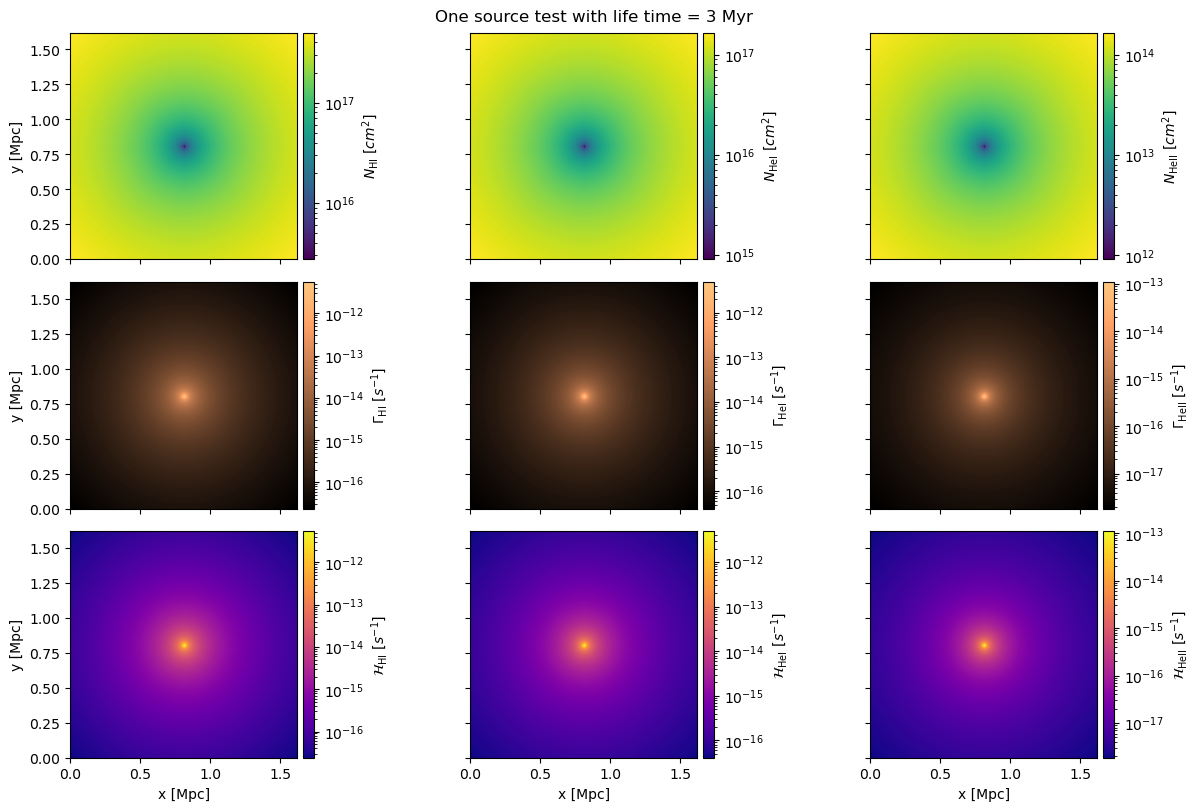

(None, None)

<Figure size 640x480 with 0 Axes>

In [10]:
# plots
fig, axs = plt.subplots(figsize=(12, 8), nrows=3, ncols=3, constrained_layout=True)
ext = [0, boxsize.value, 0, boxsize.value]

# column density
chi = coldensh_out_HI.reshape(N,N,N)
im = axs[0,0].imshow(chi[...,N//2], norm=LogNorm(), cmap='viridis', extent=ext)
plt.colorbar(im, ax=axs[0,0], label=r'$N_\mathrm{HI}$ [$cm^2$]', pad=0.02, fraction=0.048)

chei = coldensh_out_HeI.reshape(N,N,N)
im = axs[0,1].imshow(chei[...,N//2], norm=LogNorm(), cmap='viridis', extent=ext)
plt.colorbar(im, ax=axs[0,1], label=r'$N_\mathrm{HeI}$ [$cm^2$]', pad=0.02, fraction=0.048)

cheii = coldensh_out_HeII.reshape(N,N,N)
im = axs[0,2].imshow(cheii[...,N//2], norm=LogNorm(), cmap='viridis', extent=ext)
plt.colorbar(im, ax=axs[0,2], label=r'$N_\mathrm{HeII}$ [$cm^2$]', pad=0.02, fraction=0.048)

# photo-ionization
pion_HI = phi_ion_HI.reshape(N,N,N)
im = axs[1,0].imshow(pion_HI[...,N//2], norm=LogNorm(), cmap='copper', extent=ext)
plt.colorbar(im, ax=axs[1,0], label=r'$\Gamma_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

pion_HeI = phi_ion_HeI.reshape(N,N,N)
im = axs[1,1].imshow(pion_HeI[...,N//2], norm=LogNorm(), cmap='copper', extent=ext)
plt.colorbar(im, ax=axs[1,1], label=r'$\Gamma_\mathrm{HeI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

pion_HeII = phi_ion_HeII.reshape(N,N,N)
im = axs[1,2].imshow(pion_HeII[...,N//2], norm=LogNorm(), cmap='copper', extent=ext)
plt.colorbar(im, ax=axs[1,2], label=r'$\Gamma_\mathrm{HeII}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

# photo-heating
pheat_HI = phi_heat_HI.reshape(N,N,N)
im = axs[2,0].imshow(pheat_HI[...,N//2], norm=LogNorm(), cmap='plasma', extent=ext)
plt.colorbar(im, ax=axs[2,0], label=r'$\mathcal{H}_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

pheat_HeI = phi_heat_HeI.reshape(N,N,N)
im = axs[2,1].imshow(pheat_HeI[...,N//2], norm=LogNorm(), cmap='plasma', extent=ext)
plt.colorbar(im, ax=axs[2,1], label=r'$\mathcal{H}_\mathrm{HeI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

pheat_HeII = phi_heat_HeII.reshape(N,N,N)
im = axs[2,2].imshow(pheat_HeII[...,N//2], norm=LogNorm(), cmap='plasma', extent=ext)
plt.colorbar(im, ax=axs[2,2], label=r'$\mathcal{H}_\mathrm{HeII}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

for ax in axs.flatten():
    ax.set_xlabel('x [Mpc]')
    ax.set_ylabel('y [Mpc]')
    ax.label_outer()

fig.suptitle('One source test with life time = 3 Myr')
#plt.savefig('result_helium_update.png', bbox_inches='tight')
plt.show(), plt.clf()

In [10]:
# free memory
asora_he.device_close()